In [1]:
import os

In [2]:
image_data_dir = os.path.join("Dataset", "Image_Data")
gender_data_dir = os.path.join("Dataset", "Gender_Dataset")

In [3]:
import pandas as pd
df = pd.read_csv('Dataset/Attribute_Data/london_faces_info.csv')
df.head()

,face_id,face_age,face_gender,face_eth
0,1,24.0,female,white
1,2,24.0,female,white
2,3,38.0,female,white
3,4,30.0,male,white
4,5,28.0,male,east_asian


In [4]:
import math
def isnan(value):
    try:
        return math.isnan(float(value))
    except:
        return False

In [5]:
import numpy as np
import shutil

for person_no in range(1, 103):
    print('Transferring files for person ', person_no, ' ...')
    gender = df.iloc[person_no-1]['face_gender']
    if not isnan(gender):
        folder_path = os.path.join(gender_data_dir, gender)
        src_path_dir = os.path.join(image_data_dir, str(person_no))
        if not os.path.exists(folder_path):
            os.mkdir(folder_path)
        for file in os.listdir(src_path_dir):
            src = os.path.join(src_path_dir, file)
            dest = os.path.join(folder_path, file)
            if not os.path.exists(dest):
                shutil.copy(src, dest)

Transferring files for person  1  ...
Transferring files for person  2  ...
Transferring files for person  3  ...
Transferring files for person  4  ...
Transferring files for person  5  ...
Transferring files for person  6  ...
Transferring files for person  7  ...
Transferring files for person  8  ...
Transferring files for person  9  ...
Transferring files for person  10  ...
Transferring files for person  11  ...
Transferring files for person  12  ...
Transferring files for person  13  ...
Transferring files for person  14  ...
Transferring files for person  15  ...
Transferring files for person  16  ...
Transferring files for person  17  ...
Transferring files for person  18  ...
Transferring files for person  19  ...
Transferring files for person  20  ...
Transferring files for person  21  ...
Transferring files for person  22  ...
Transferring files for person  23  ...
Transferring files for person  24  ...
Transferring files for person  25  ...
Transferring files for person  26 

In [5]:
import tensorflow as tf
img_height,img_width=256,256
batch_size=16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  gender_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2040 files belonging to 2 classes.
Using 1632 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  gender_data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2040 files belonging to 2 classes.
Using 204 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  gender_data_dir,
  validation_split=0.1,
  subset="validation",
  seed=1,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2040 files belonging to 2 classes.
Using 204 files for validation.


In [8]:
classnames = train_ds.class_names

In [9]:
classnames

['female', 'male']

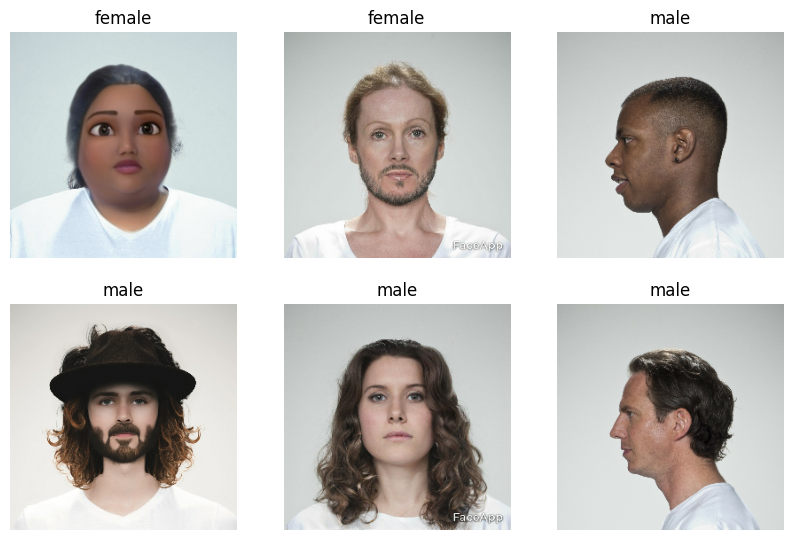

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[np.argmax(labels[i])])
    plt.axis("off")

In [11]:
model = tf.keras.models.load_model('weights/action.h5', compile=False)
dense_output_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)
dense_output_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50_input (InputLayer)  [(None, 256, 256, 3)]    0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 inception-resnet-v1 (Functi  (None, 1, 1, 2048)       1281536   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 24,869,248
Trainable params: 1,280,512
Non-trainable params: 23,588,736
_________________________________________________________________


In [12]:
genders = ['female', 'male']

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, PReLU, Dropout

gender_model = Sequential()
gender_model.add(dense_output_model)
gender_model.add(Dense(len(genders), activation='softmax'))

In [14]:
gender_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              24869248  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 24,873,346
Trainable params: 1,284,610
Non-trainable params: 23,588,736
_________________________________________________________________


In [16]:
gender_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
epochs = 2
history = gender_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/2
102/102 [==============================] - 282s 3s/step - loss: 0.1691 - accuracy: 0.9283 - val_loss: 0.1341 - val_accuracy: 0.9608
Epoch 2/2
102/102 [==============================] - 293s 3s/step - loss: 0.0605 - accuracy: 0.9786 - val_loss: 0.0923 - val_accuracy: 0.9706


In [18]:
test_loss, test_accuracy = gender_model.evaluate(test_ds)

13/13 [==============================] - 35s 3s/step - loss: 0.0116 - accuracy: 0.9951


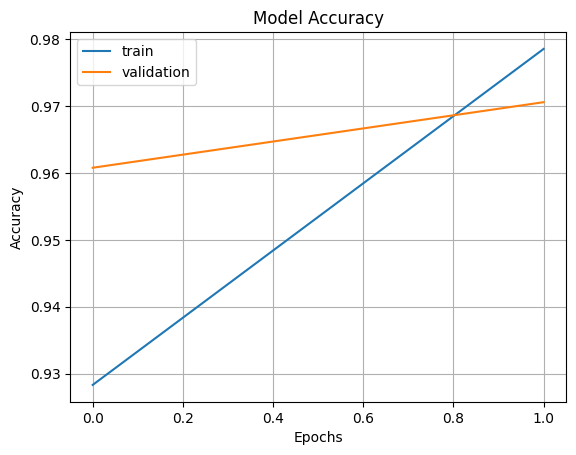

In [19]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
#plt.savefig('model_accuracy_rf.pdf', dpi = 700)

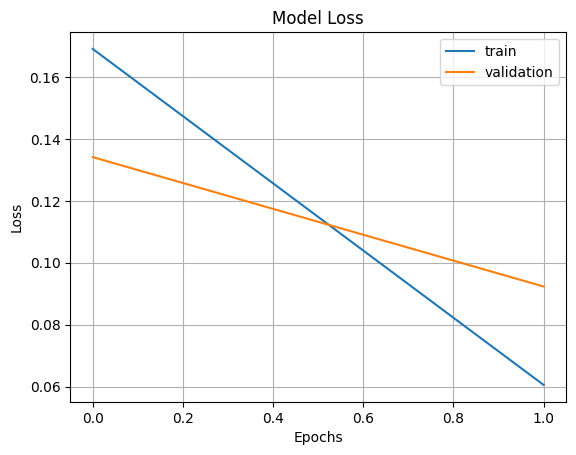

In [20]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
#plt.savefig('model_loss_rf.pdf', dpi = 700)

In [21]:
gender_model.save("weights/action_gender.h5")

In [22]:
gender_model = tf.keras.models.load_model('weights/action_gender.h5')

In [23]:
import cv2

In [46]:
gender_baseline, gender_filters, filter_no_list, mispredictions = [], [], [], {'male': {}, 'female':{}}

for person_no in range(1, 103):
    person_dir = os.path.join(image_data_dir, str(person_no))
    img_path = os.path.join(person_dir, "{}_Original.jpg".format(person_no))
    img = cv2.imread(img_path)
    image_resized = cv2.resize(img, (img_height, img_width))
    image = np.expand_dims(image_resized, axis=0)
    print('Calculating gender for baseline image of person ', person_no, '...')
    pred = gender_model.predict(image)
    baseline_gender_pred = genders[np.argmax(pred)]
    
    for filter_no in range(1, 11):
        img_path = os.path.join(person_dir, "{}_Filtered_{}.jpg".format(person_no, filter_no))
        img = cv2.imread(img_path)
        image_resized = cv2.resize(img, (img_height, img_width))
        image = np.expand_dims(image_resized, axis=0)
        print('Calculating gender for filter ',filter_no,' for person ', person_no, '...')
        pred = gender_model.predict(image)
        filtered_gender_pred = genders[np.argmax(pred)]
        actual_gender = df.iloc[person_no-1]['face_gender']
        
        if filtered_gender_pred != actual_gender:
            count = mispredictions[actual_gender].get("Filter_{}".format(filter_no), 0)
            mispredictions[actual_gender]["Filter_{}".format(filter_no)] = count+1
        
        gender_baseline.append(baseline_gender_pred)
        gender_filters.append(filtered_gender_pred)
        filter_no_list.append(filter_no)

Calculating gender for baseline image of person  1 ...
Calculating gender for filter  1  for person  1 ...
Calculating gender for filter  2  for person  1 ...
Calculating gender for filter  3  for person  1 ...
Calculating gender for filter  4  for person  1 ...
Calculating gender for filter  5  for person  1 ...
Calculating gender for filter  6  for person  1 ...
Calculating gender for filter  7  for person  1 ...
Calculating gender for filter  8  for person  1 ...
Calculating gender for filter  9  for person  1 ...
Calculating gender for filter  10  for person  1 ...
Calculating gender for baseline image of person  2 ...
Calculating gender for filter  1  for person  2 ...
Calculating gender for filter  2  for person  2 ...
Calculating gender for filter  3  for person  2 ...
Calculating gender for filter  4  for person  2 ...
Calculating gender for filter  5  for person  2 ...
Calculating gender for filter  6  for person  2 ...
Calculating gender for filter  7  for person  2 ...
Calcu

Calculating gender for filter  2  for person  15 ...
Calculating gender for filter  3  for person  15 ...
Calculating gender for filter  4  for person  15 ...
Calculating gender for filter  5  for person  15 ...
Calculating gender for filter  6  for person  15 ...
Calculating gender for filter  7  for person  15 ...
Calculating gender for filter  8  for person  15 ...
Calculating gender for filter  9  for person  15 ...
Calculating gender for filter  10  for person  15 ...
Calculating gender for baseline image of person  16 ...
Calculating gender for filter  1  for person  16 ...
Calculating gender for filter  2  for person  16 ...
Calculating gender for filter  3  for person  16 ...
Calculating gender for filter  4  for person  16 ...
Calculating gender for filter  5  for person  16 ...
Calculating gender for filter  6  for person  16 ...
Calculating gender for filter  7  for person  16 ...
Calculating gender for filter  8  for person  16 ...
Calculating gender for filter  9  for pers

Calculating gender for filter  2  for person  29 ...
Calculating gender for filter  3  for person  29 ...
Calculating gender for filter  4  for person  29 ...
Calculating gender for filter  5  for person  29 ...
Calculating gender for filter  6  for person  29 ...
Calculating gender for filter  7  for person  29 ...
Calculating gender for filter  8  for person  29 ...
Calculating gender for filter  9  for person  29 ...
Calculating gender for filter  10  for person  29 ...
Calculating gender for baseline image of person  30 ...
Calculating gender for filter  1  for person  30 ...
Calculating gender for filter  2  for person  30 ...
Calculating gender for filter  3  for person  30 ...
Calculating gender for filter  4  for person  30 ...
Calculating gender for filter  5  for person  30 ...
Calculating gender for filter  6  for person  30 ...
Calculating gender for filter  7  for person  30 ...
Calculating gender for filter  8  for person  30 ...
Calculating gender for filter  9  for pers

Calculating gender for filter  2  for person  43 ...
Calculating gender for filter  3  for person  43 ...
Calculating gender for filter  4  for person  43 ...
Calculating gender for filter  5  for person  43 ...
Calculating gender for filter  6  for person  43 ...
Calculating gender for filter  7  for person  43 ...
Calculating gender for filter  8  for person  43 ...
Calculating gender for filter  9  for person  43 ...
Calculating gender for filter  10  for person  43 ...
Calculating gender for baseline image of person  44 ...
Calculating gender for filter  1  for person  44 ...
Calculating gender for filter  2  for person  44 ...
Calculating gender for filter  3  for person  44 ...
Calculating gender for filter  4  for person  44 ...
Calculating gender for filter  5  for person  44 ...
Calculating gender for filter  6  for person  44 ...
Calculating gender for filter  7  for person  44 ...
Calculating gender for filter  8  for person  44 ...
Calculating gender for filter  9  for pers

Calculating gender for filter  2  for person  57 ...
Calculating gender for filter  3  for person  57 ...
Calculating gender for filter  4  for person  57 ...
Calculating gender for filter  5  for person  57 ...
Calculating gender for filter  6  for person  57 ...
Calculating gender for filter  7  for person  57 ...
Calculating gender for filter  8  for person  57 ...
Calculating gender for filter  9  for person  57 ...
Calculating gender for filter  10  for person  57 ...
Calculating gender for baseline image of person  58 ...
Calculating gender for filter  1  for person  58 ...
Calculating gender for filter  2  for person  58 ...
Calculating gender for filter  3  for person  58 ...
Calculating gender for filter  4  for person  58 ...
Calculating gender for filter  5  for person  58 ...
Calculating gender for filter  6  for person  58 ...
Calculating gender for filter  7  for person  58 ...
Calculating gender for filter  8  for person  58 ...
Calculating gender for filter  9  for pers

Calculating gender for filter  2  for person  71 ...
Calculating gender for filter  3  for person  71 ...
Calculating gender for filter  4  for person  71 ...
Calculating gender for filter  5  for person  71 ...
Calculating gender for filter  6  for person  71 ...
Calculating gender for filter  7  for person  71 ...
Calculating gender for filter  8  for person  71 ...
Calculating gender for filter  9  for person  71 ...
Calculating gender for filter  10  for person  71 ...
Calculating gender for baseline image of person  72 ...
Calculating gender for filter  1  for person  72 ...
Calculating gender for filter  2  for person  72 ...
Calculating gender for filter  3  for person  72 ...
Calculating gender for filter  4  for person  72 ...
Calculating gender for filter  5  for person  72 ...
Calculating gender for filter  6  for person  72 ...
Calculating gender for filter  7  for person  72 ...
Calculating gender for filter  8  for person  72 ...
Calculating gender for filter  9  for pers

Calculating gender for filter  2  for person  85 ...
Calculating gender for filter  3  for person  85 ...
Calculating gender for filter  4  for person  85 ...
Calculating gender for filter  5  for person  85 ...
Calculating gender for filter  6  for person  85 ...
Calculating gender for filter  7  for person  85 ...
Calculating gender for filter  8  for person  85 ...
Calculating gender for filter  9  for person  85 ...
Calculating gender for filter  10  for person  85 ...
Calculating gender for baseline image of person  86 ...
Calculating gender for filter  1  for person  86 ...
Calculating gender for filter  2  for person  86 ...
Calculating gender for filter  3  for person  86 ...
Calculating gender for filter  4  for person  86 ...
Calculating gender for filter  5  for person  86 ...
Calculating gender for filter  6  for person  86 ...
Calculating gender for filter  7  for person  86 ...
Calculating gender for filter  8  for person  86 ...
Calculating gender for filter  9  for pers

Calculating gender for filter  2  for person  99 ...
Calculating gender for filter  3  for person  99 ...
Calculating gender for filter  4  for person  99 ...
Calculating gender for filter  5  for person  99 ...
Calculating gender for filter  6  for person  99 ...
Calculating gender for filter  7  for person  99 ...
Calculating gender for filter  8  for person  99 ...
Calculating gender for filter  9  for person  99 ...
Calculating gender for filter  10  for person  99 ...
Calculating gender for baseline image of person  100 ...
Calculating gender for filter  1  for person  100 ...
Calculating gender for filter  2  for person  100 ...
Calculating gender for filter  3  for person  100 ...
Calculating gender for filter  4  for person  100 ...
Calculating gender for filter  5  for person  100 ...
Calculating gender for filter  6  for person  100 ...
Calculating gender for filter  7  for person  100 ...
Calculating gender for filter  8  for person  100 ...
Calculating gender for filter  9 

In [47]:
data_dict = {'face_id':[], 'filter_no':[], 'actual_gender':[], 'predicted_gender_baseline':[], 'predicted_gender_filtered':[]}

In [48]:
persons = len(gender_baseline)/10

In [49]:
for i in range(int(persons)):
    face_id = df.iloc[i]['face_id']
    for filter_no in range(1, 11):
        data_dict['face_id'].append(face_id)

In [50]:
data_dict['filter_no'] = filter_no_list
data_dict['predicted_gender_baseline'] = gender_baseline
data_dict['predicted_gender_filtered'] = gender_filters

In [51]:
for i in range(int(persons)):
    gender = df.iloc[i]['face_gender']
    for filter_no in range(1, 11):
        data_dict['actual_gender'].append(gender)

In [52]:
df_gender = pd.DataFrame.from_dict(data_dict)
df_gender.head()

,face_id,filter_no,actual_gender,predicted_gender_baseline,predicted_gender_filtered
0,1,1,female,female,female
1,1,2,female,female,female
2,1,3,female,female,female
3,1,4,female,female,female
4,1,5,female,female,female


In [53]:
mispredictions

{'male': {'Filter_8': 4, 'Filter_2': 3, 'Filter_10': 1},
 'female': {'Filter_3': 3,
  'Filter_6': 1,
  'Filter_8': 2,
  'Filter_4': 1,
  'Filter_7': 1,
  'Filter_10': 1}}

In [33]:
import pickle
with open("Results/Numerical Analysis/gender_dict.pkl", "wb") as f:
    pickle.dump(df_gender, f)

In [2]:
import os
import pickle
if os.path.exists("Results/Numerical Analysis/gender_dict.pkl"):
    with open("Results/Numerical Analysis/gender_dict.pkl", "rb") as f:
        df_gender = pickle.load(f)

In [3]:
df_gender

,face_id,filter_no,actual_gender,predicted_gender_baseline,predicted_gender_filtered
0,1,1,female,female,female
1,1,2,female,female,female
2,1,3,female,female,female
3,1,4,female,female,female
4,1,5,female,female,female
...,...,...,...,...,...
1015,173,6,male,male,male
1016,173,7,male,male,male
1017,173,8,male,male,male
1018,173,9,male,male,male


In [9]:
import numpy as np
gender_true = np.array(df_gender['actual_gender'])
gender_pred = np.array(df_gender['predicted_gender_filtered'])

In [10]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
(precision, recall, f1_score, _) = precision_recall_fscore_support(gender_true, gender_pred, average='macro')
accuracy = accuracy_score(gender_true, gender_pred)

In [11]:
precision, recall, f1_score, accuracy

(0.9833454646286091,
 0.9832691567192915,
 0.9833063610081263,
 0.9833333333333333)

In [36]:
import pickle
with open("Results/Numerical Analysis/mispredictions_gender.pkl", "wb") as f:
    pickle.dump(mispredictions, f)

In [37]:
if os.path.exists("Results/Numerical Analysis/mispredictions_gender.pkl"):
    with open("Results/Numerical Analysis/mispredictions_gender.pkl", "rb") as f:
        mispredictions = pickle.load(f)